# **Atividade avaliativa - Projeto de análise de dados disponíveis na Web**
Nome: Ana Paula Pacca da Silva

*Bibliotecas*

In [1]:
from bs4 import BeautifulSoup
import requests as req
from time import time
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import nltk as nl
from wordcloud import WordCloud, ImageColorGenerator
import re
from nltk.sentiment import SentimentIntensityAnalyzer
import operator
import nltk
import numpy as np
nltk.downloader.download('vader_lexicon')
nl.download('punkt')
sia = SentimentIntensityAnalyzer()
from nltk.text import Text
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk import ngrams
import pandas as pd
import openpyxl
!pip install unidecode
from unidecode import unidecode
from nltk import SnowballStemmer
import nltk.corpus
import matplotlib.patches as mpatches

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 6.0 MB/s eta 0:00:00


# **Recuperação de conteúdo**

URL Base: Todas as páginas do Rotten Tomatoes com a tag "Best and Worst"

In [2]:
url_principal = 'https://editorial.rottentomatoes.com/tag/best-and-worst'
doc = req.get(url_principal)
src = doc.content

Navegando e listando todas as urls com a tag "best and worst"

In [3]:
page_id = 0
next = ""
lista_url = []

while next != "stop":
   # Construir URL
    if page_id == 0:
        url = url_principal
        lista_url.append(url)
        page_id+=1
    else:
        url = url_principal + "/page/" + str(page_id)
        head_url = req.head(url)
        if head_url.status_code != 404: # Confirmar se a página existe
          lista_url.append(url)
          page_id+=1
        else:
          next = "stop"

Listando os links dos artigos que compões todas as páginas

In [4]:
links = []

for url in lista_url:
  doc = req.get(url)
  src = doc.content
  documento = BeautifulSoup(src, 'html.parser')


  for link in documento.find('div', class_='panel-body').find_all('a',  attrs={'class':'unstyled articleLink'}):
      links.append(link['href'])

links = [x for x in links if x is not None]

Construindo função para recuperação de conteúdo 

In [5]:
class IndicePaginas:
    LISTA_PAGINAS = {}
    
    def adiciona_pagina(self, url, pagina):
          self.LISTA_PAGINAS[url]=pagina
    
    def verifica_url(self, url):
          return url in self.LISTA_PAGINAS.keys()
    
    def recupera_paginas(self):
          return self.LISTA_PAGINAS
        
class Pagina():
    def __init__(self,url, expires, content):
        self.url = url
        self.expires = expires
        self.content = content

def encontra_links(url_atual, url_origem, nivel_pagina, nivel_maximo, indice_paginas):
    nivel_atual = nivel_pagina + 1
    if nivel_atual < nivel_maximo:
        print("Nível atual: " + str(nivel_atual))
        print("Recuperando: " + url_atual)
        if not indice_paginas.verifica_url(url_atual):
            doc = req.get(url_atual)
            src = doc.content
            documento = BeautifulSoup(src, 'html.parser')
            pagina = Pagina(url_atual, doc.headers.get('expires'), documento)
            indice_paginas.adiciona_pagina(url_atual, pagina)
            for url_now in documento.find_all('unstyled articleLink', href=True):
                x = url_now['href'].split('?')[0] if url_now['href'].find('?') > 0 else url_now['href']
                if url_origem in x:
                    if not indice_paginas.verifica_url(x):
                        encontra_links(x, url_origem, nivel_atual, nivel_maximo,indice_paginas)

Recuperando conteúdo de cada url da lista

In [6]:
indice_paginas = IndicePaginas()
erros = []
#essa url específica apresenta erro na recuperação ds dados
#('https://editorial.rottentomatoes.com/guide/all-wes-anderson-movies-ranked-by-tomatometer/')


#ignora iterações com  erro e armazena o erro em uma lista
links = [i for j, i in enumerate(links) if i not in links[:j]] 

for url_base in links:
  try:
    encontra_links(url_base, url_base, 0, 4, indice_paginas)
  except Exception as ex:
    print("Erro recuperando url:", ex)
    erros.append(ex)
    pass

#armazena a url que gerou o erro em duas listas diferentes, para análises e histórico que sejam necessárias no futuro
urls_erro = []

for i in erros:
  url_erro = ("https://" + str(i).split('//')[1].split('/ ')[0])
  urls_erro.append(url_erro)
  urls_erro = [i for j, i in enumerate(urls_erro) if i not in urls_erro[:j]] 

Nível atual: 1
Recuperando: https://editorial.rottentomatoes.com/guide/oscars-best-and-worst-best-pictures/
Nível atual: 1
Recuperando: https://editorial.rottentomatoes.com/guide/all-marvel-cinematic-universe-movies-ranked/
Nível atual: 1
Recuperando: https://editorial.rottentomatoes.com/guide/jurassic-park-world-movies/
Nível atual: 1
Recuperando: https://editorial.rottentomatoes.com/guide/best-fantasy-movies-of-all-time/
Nível atual: 1
Recuperando: https://editorial.rottentomatoes.com/article/11-worst-movie-thanksgivings-ever/
Nível atual: 1
Recuperando: https://editorial.rottentomatoes.com/guide/best-horror-movies-of-all-time/
Nível atual: 1
Recuperando: https://editorial.rottentomatoes.com/guide/oscar-ceremonies-ranked-best-and-worst-academy-awards/
Nível atual: 1
Recuperando: https://editorial.rottentomatoes.com/article/awards-leaderboard-top-movies-of-2019/
Nível atual: 1
Recuperando: https://editorial.rottentomatoes.com/article/awards-leaderboard-top-movies-of-2018/
Nível atual:

In [7]:
print(len(links)-len(erros), "páginas recuperadas")
print(len(erros), "páginas retornaram erro")

print("\nURLS que retornaram erro: ")
for i in urls_erro:
  print(i)

93 páginas recuperadas
1 páginas retornaram erro

URLS que retornaram erro: 
https://editorialadmin.rottentomatoes.com/guide/all-wes-anderson-movies-ranked


Armazenar título e conteúdo de cada página

In [8]:
texto = ""
titulo = []
lista_texto = []
url_page = []

lista = indice_paginas.recupera_paginas()
for entrada in lista:
    pagina_now = lista[entrada]

    #armazenar url de cada página
    url_page.append(entrada)
  
    #armazenar conteúdo de cada página em string única
    texto += str.join(' ',[ x.getText() for x in pagina_now.content.find_all('div',{'class':'articleContentBody'})])
    
    #armazenar título de cada página (caso não seja encontrada a tag <h1> será atribuído "None")
    if pagina_now.content.find('h1') != None: 
      titulo.append(pagina_now.content.find('h1').text)
    else:
      titulo.append('Sem titulo')

    #armazenar conteúdo de cada página como item num vetor 
    lista_texto.append([x.getText() for x in pagina_now.content.find_all('div',{'class':'articleContentBody'})])

Agregando valores a stopwords

In [9]:
nl.download('stopwords')
stopwords = nl.corpus.stopwords.words('english')

stopwords.extend(['list','with','whose', 'your', 'much', 'best', 'rank', 'ranked', 'work', 'cast', 'role', 'still', 'back', 'find', 'thing', 'got', 'look', 'photo', 'will', 'movie','film', 'take', 'like', 'watch','trailer','movies', 'might', 'see', 'films', 'made','make','new','year', 'first', 'may', 'get', 'wrote','one','time', 'including', 'director', 'years', 'whose', 'also', 'story', 'way', 'even', 'many', 'Tomatometer', 'would', 'star', 'character' 'first', 'could', 'character'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Calculando a frequência de cada palavra no texto compilado

In [10]:
nl.download('punkt')
texto_now = Text(word_tokenize((texto.lower())), name = 'texto_base')

fd1 = FreqDist(texto_now)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Construindo dataframe **(df)** com relação de palavras, tamanho e frequencia de cada uma delas no texto compilado

In [11]:
pontuacao = [".", ",", ";", "-", ":","!","?","&","#", " ", "–", "—", "{", "|", "}", "‘", "’", "“", "”", "©", "…"]
vocabulario = [v for v in sorted(set(texto_now)) if not v in pontuacao]
palavras = []
frequencia = []
tamanho = []

for w in vocabulario:
  if len(w) > 3: #ignora palavras com tamanho inferior a 3 caracteres
    palavras.append(w)
    frequencia.append(fd1[w])
    tamanho.append(len(w))

df = pd.DataFrame ({'palavras': palavras, 'frequencia': frequencia, 'tamanho': tamanho})

df

,palavras,frequencia,tamanho
0,'50s,2,4
1,'70s,1,4
2,'80s,1,4
3,'90s,2,4
4,'great,1,6
...,...,...,...
17196,—alex,11,5
17197,—filmography,1,12
17198,…about,1,6
17199,…but,1,4


Criando dataframe **(df1)** com o titulo, conteúdo, tamanho e classificação de cada página

In [12]:
df1 = pd.DataFrame ({'titulo': titulo, 'conteudo': lista_texto, 'url': url_page})

df1["conteudo"] = (df1["conteudo"]
                   .explode()
                   .str
                   .replace(r"\n", "", regex=True)
                  )

df1["tamanho"] = (df1["conteudo"]
                   .explode()
                   .str
                   .len()
                  )

# classifica cada linha como "Melhores, Piores, Melhores e Piores" de acordo com a ocorrência das palavras
# "best", "worst" ou ambas no título. No caso de nenhuma ocorrência é atribuído valor NaN
df1['Classificação'] =  (df1['titulo'].
                         apply(lambda x: "Melhores e Piores" if "worst" in x.lower() and "Best" in x else (
                             "Melhores" if "Best" in x else ("Piores" if "worst" in x.lower() else ("Melhores e Piores" if "rank" in x.lower() else np.nan)))
                         ))

#elimina do dataframe todas as linhas cujo conteúdo da página não pode ser recuperado (na última execução, o dataframe passou de 93 a 86 linhas)
df1 = df1[df1['conteudo'].notnull()]

df1

,titulo,conteudo,url,tamanho,Classificação
0,"All 96 Best Picture Winners, Ranked by Tomatom...",(Photo by A24/courtesy Everett Collection)All ...,https://editorial.rottentomatoes.com/guide/osc...,48075.0,Melhores
1,"All Marvel Cinematic Universe Movies, Ranked B...",(Photo by @ Walt Disney Studios Motion Picture...,https://editorial.rottentomatoes.com/guide/all...,17864.0,Melhores e Piores
2,All Jurassic Park and World Movies Ranked by T...,All Jurassic Park and World Movies Ranked by T...,https://editorial.rottentomatoes.com/guide/jur...,3901.0,Melhores e Piores
3,Best Fantasy Movies of All Time,Best Fantasy Movies of All TimeWelcome to Rott...,https://editorial.rottentomatoes.com/guide/bes...,40274.0,Melhores
4,11 Most Disastrous Movie Thanksgivings Ever,"Everyone has the day off work, there’s a big b...",https://editorial.rottentomatoes.com/article/1...,11716.0,NaN
...,...,...,...,...,...
83,10 Disastrous Disaster Movies,This weekend’s San Andreas imagines a devastat...,https://editorial.rottentomatoes.com/article/1...,10021.0,NaN
84,The Tomatometer Guide to Disneyland,Tomorrowland is the first film to be named aft...,https://editorial.rottentomatoes.com/article/t...,11890.0,NaN
86,Reese Witherspoon's 10 Best Movies,She’s one of the highest-paid stars in Hollywo...,https://editorial.rottentomatoes.com/article/t...,8680.0,Melhores
91,Awards Leaderboard: Top Movies of 2014,"Awards season is on, and with everything that ...",https://editorial.rottentomatoes.com/article/a...,6492.0,NaN


Aplicando análise de sentimento (SentimentIntensityAnalyzer) aos títulos com valor NaN na coluna classicação. 

In [13]:
#calcula score do sentimento
df1["sentiment_score"] = df1["titulo"].apply(lambda x: sia.polarity_scores(x)["compound"])

# classifica entre "Melhores, Piores e Outras" de acordo com o score do sentimento
df1["Classificação_AS"] = np.select([df1["sentiment_score"] < 0, df1["sentiment_score"] == 0, df1["sentiment_score"] > 0],
                           ['Piores', 'Outras', 'Melhores'])

#cria a coluna classe com os valores da coluna "Classificação", substituindo os valors NaN pelos presentes na coluna "Classificação_AS"
df1['classe'] = df1["Classificação"].fillna(df1["Classificação_AS"])

#elimina colunas auxiliares
df1.drop(['sentiment_score', 'Classificação_AS', 'Classificação'], inplace=True, axis=1)
df1

,titulo,conteudo,url,tamanho,classe
0,"All 96 Best Picture Winners, Ranked by Tomatom...",(Photo by A24/courtesy Everett Collection)All ...,https://editorial.rottentomatoes.com/guide/osc...,48075.0,Melhores
1,"All Marvel Cinematic Universe Movies, Ranked B...",(Photo by @ Walt Disney Studios Motion Picture...,https://editorial.rottentomatoes.com/guide/all...,17864.0,Melhores e Piores
2,All Jurassic Park and World Movies Ranked by T...,All Jurassic Park and World Movies Ranked by T...,https://editorial.rottentomatoes.com/guide/jur...,3901.0,Melhores e Piores
3,Best Fantasy Movies of All Time,Best Fantasy Movies of All TimeWelcome to Rott...,https://editorial.rottentomatoes.com/guide/bes...,40274.0,Melhores
4,11 Most Disastrous Movie Thanksgivings Ever,"Everyone has the day off work, there’s a big b...",https://editorial.rottentomatoes.com/article/1...,11716.0,Piores
...,...,...,...,...,...
83,10 Disastrous Disaster Movies,This weekend’s San Andreas imagines a devastat...,https://editorial.rottentomatoes.com/article/1...,10021.0,Piores
84,The Tomatometer Guide to Disneyland,Tomorrowland is the first film to be named aft...,https://editorial.rottentomatoes.com/article/t...,11890.0,Outras
86,Reese Witherspoon's 10 Best Movies,She’s one of the highest-paid stars in Hollywo...,https://editorial.rottentomatoes.com/article/t...,8680.0,Melhores
91,Awards Leaderboard: Top Movies of 2014,"Awards season is on, and with everything that ...",https://editorial.rottentomatoes.com/article/a...,6492.0,Melhores


# **Análise de Dados**

Buscador de palavras

In [14]:
palavra_pesquisa = 'john'
texto_nowt = Text(word_tokenize(texto), name = 'texto_base')
texto_nowt.concordance(palavra_pesquisa)

Displaying 25 of 223 matches:
arring : Lew Ayres , Louis Wolheim , John Wray , Raymond Griffith Directed By 
s to investigate allegations against John Geoghan , ... [ More ] Starring : Ma
 Joanne Dru , Mercedes McCambridge , John Ireland Directed By : Robert Rossen 
leck , Bryan Cranston , Alan Arkin , John Goodman Directed By : Ben Affleck # 
ng : Jean Dujardin , Bérénice Bejo , John Goodman , James Cromwell Directed By
 is enlivened by a terrific cast and John Ford 's ineffable directorial eye . 
cDowall , Donald Crisp Directed By : John Ford # 44 Wings ( 1927 ) 93 % # 44 A
frey Rush , Judi Dench Directed By : John Madden # 47 West Side Story ( 1961 )
 Meredith , Burt Young Directed By : John G. Avildsen # 53 The Life of Emile Z
Score : 102353 % Critics Consensus : John Schlesinger 's gritty , unrelentingl
offman , Jon Voight , Sylvia Miles , John McGiver Directed By : John Schlesing
a Miles , John McGiver Directed By : John Schlesinger # 62 Gandhi ( 1982 ) 89 
sley , Candice Bergen 

Nuvem de palavras com as palavras do texto compilado (texto de todas as páginas recuperadas)

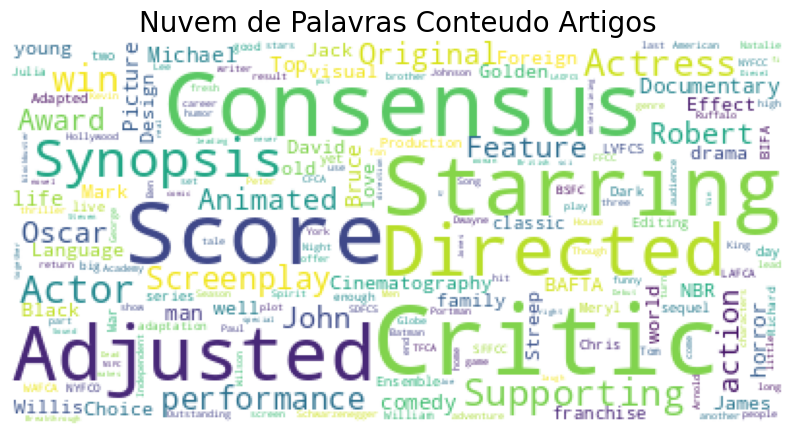

In [15]:
def PlotaWordCloud(string, titulo):
  wordcloud_texto2 = WordCloud(stopwords=stopwords, background_color='white', max_font_size = 50,collocations=False).generate(string)
  plt.figure(figsize=((10,8)))
  plt.imshow(wordcloud_texto2)
  plt.axis('off')
  plt.title(titulo, fontsize = 20)

  #exibe e armazena gráfico
  plt.savefig('wordcloud2.png', bbox_inches="tight")
  plt.show()

PlotaWordCloud(texto, "Nuvem de Palavras Conteudo Artigos")

Nuvem de palavras com os radicais das palavras do texto compilado

In [16]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

In [17]:
def processCorpus(corpus, language):   
    stopwords = nltk.corpus.stopwords.words(language)
    param_stemmer = SnowballStemmer(language)
    
    for document in corpus:
        index = corpus.index(document)
        corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        
        listOfTokens = applyStemming(listOfTokens, param_stemmer)

        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])
    return corpus

In [18]:
#converte lista de radicais para string
def ListaString(lista):
  novastring = ''
  language = 'english'
  corpus = processCorpus(lista, language)
  for x in corpus:
    novastring += x
  return novastring

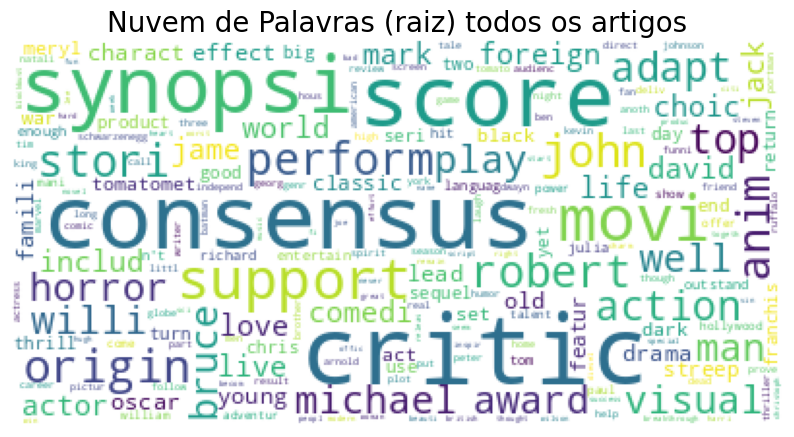

In [19]:
total = df1['conteudo'].tolist()
mystring = ListaString(total)
PlotaWordCloud(mystring, "Nuvem de Palavras (raiz) todos os artigos")

Nuvem de palavras para as palavras dos artigos classificados como "Melhores"

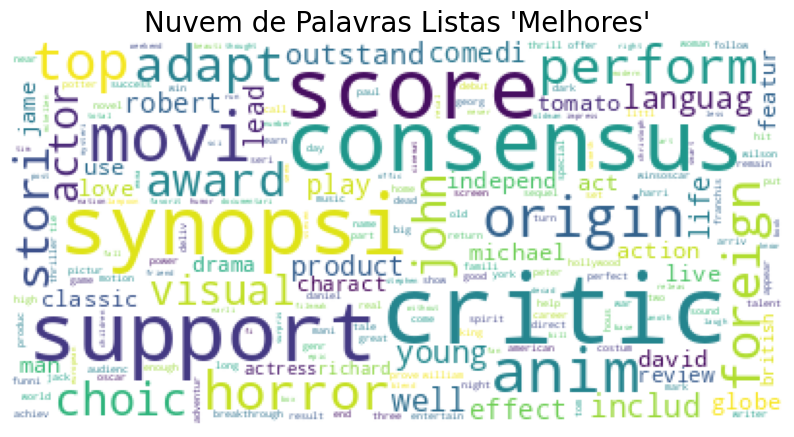

In [20]:
df1_melhores = df1[df1['classe']== 'Melhores']
melhores = df1_melhores['conteudo'].tolist()
mystring_melhores = ListaString(melhores)
PlotaWordCloud(mystring_melhores, "Nuvem de Palavras Listas 'Melhores'")

Nuvem de palavras para as palavras dos artigos classificados como "Piores"

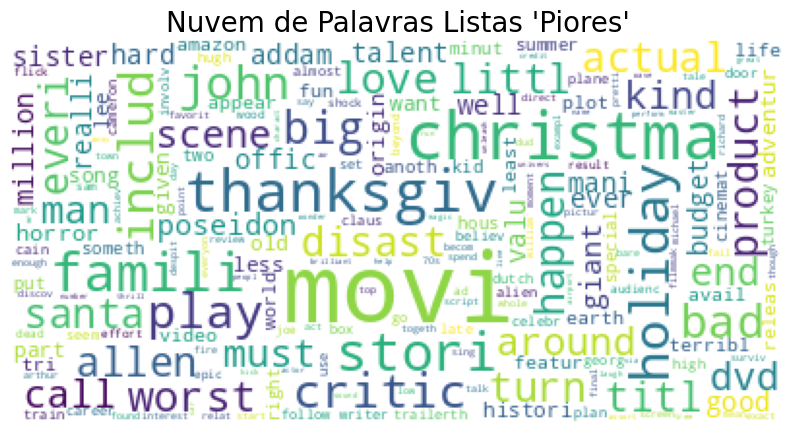

In [21]:
df1_piores = df1[df1['classe']== 'Piores']
piores = df1_piores['conteudo'].tolist()
mystring_piores = ListaString(piores)
PlotaWordCloud(mystring_piores, "Nuvem de Palavras Listas 'Piores'")

Nuvem de palavras para as palavras dos artigos classificados como "Melhoes e Piores"

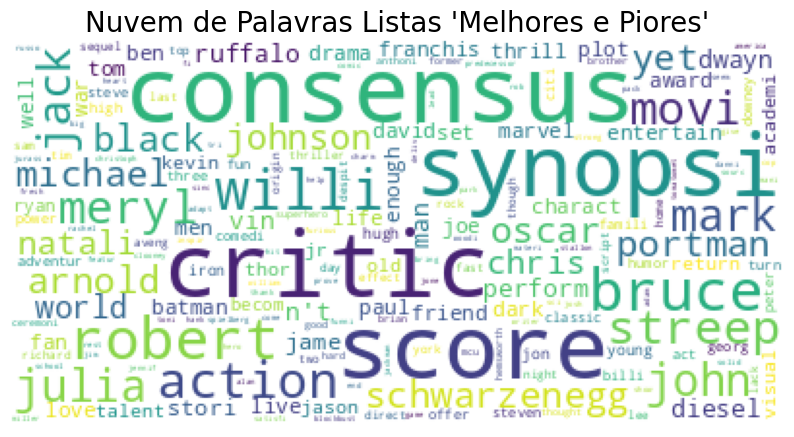

In [22]:
df1_melhorespiores = df1[df1['classe']== 'Melhores e Piores']
melhorespiores = df1_melhorespiores['conteudo'].tolist()
mystring_melhorespiores = ListaString(melhorespiores)
PlotaWordCloud(mystring_melhorespiores, "Nuvem de Palavras Listas 'Melhores e Piores'")

Nuvem de palavras para as palavras dos artigos classificados como "Outros"

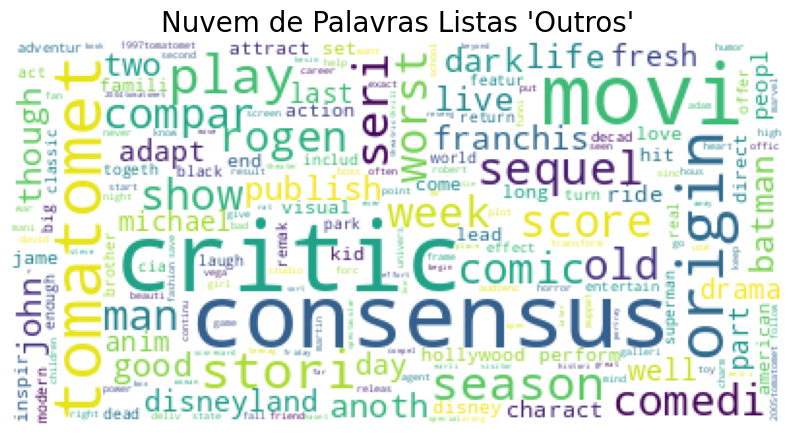

In [23]:
df1_outros = df1[df1['classe']== 'Outras']
outros = df1_outros['conteudo'].tolist()
mystring_outros = ListaString(outros)
PlotaWordCloud(mystring_outros, "Nuvem de Palavras Listas 'Outros'")

Gráfico de barras horizontais com o top 10 palavras mais recorrentes

In [24]:
#cria dataframe com palavras reduzidas aos seus radicais

def FrequenciaWords(texto):
  texto_reduc = Text(word_tokenize((texto.lower())), name = 'texto_base')

  fd2 = FreqDist(texto_reduc)

  vocabulario2 = [v for v in sorted(set(texto_reduc)) if not v in pontuacao]
  palavras = []
  frequencia = []

  for w in vocabulario2:
    if len(w) > 3: #ignora palavras com tamanho inferior a 3 caracteres
      palavras.append(w)
      frequencia.append(fd2[w])

  dfw = pd.DataFrame ({'palavras': palavras, 'frequencia': frequencia})

  #remove stop words
  dfw = dfw[~dfw["palavras"].isin(stopwords)]
  return dfw

In [25]:
def TopN(frequencia, titulo):
  #agrupa dataframe com top 10 linhas, de acordo com a coluna "frequencia"
  top_nw = frequencia.sort_values(by=['frequencia'], ascending=[False]).head(10)
  top_nw.sort_values('frequencia',inplace=True)

  x = top_nw['palavras']
  y = top_nw['frequencia']

  plt.figure(figsize=((8,6)))

  plt.xlabel("frequencia")
  plt.ylabel("palavras")
  plt.title(titulo)
  bars2 = plt.barh(x, y, color = "#8CEDCB")

  #adiciona rótulo de dados
  for i,values in enumerate(y):
    plt.text(values, i, '%s' %values)
  
  #exibe e armazena gráfico
  plt.savefig('grafico1.png', bbox_inches="tight")
  plt.show()


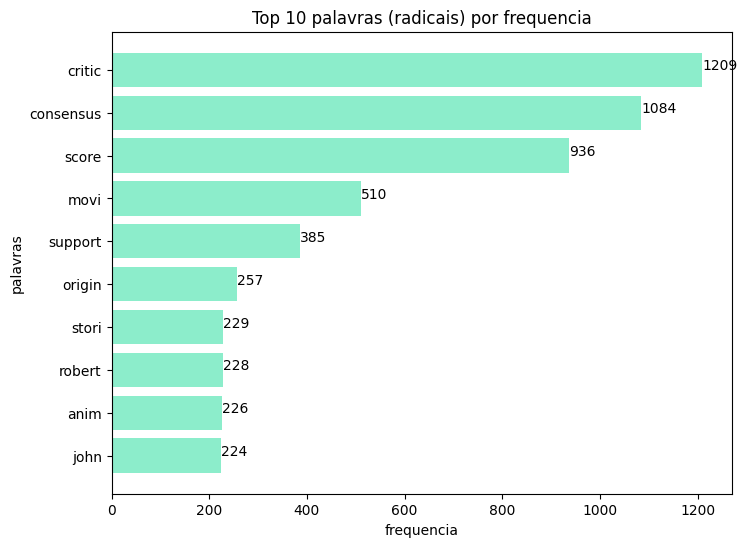

In [26]:
TopN(FrequenciaWords(mystring), "Top 10 palavras (radicais) por frequencia")

Gráfico de barras horizontais com o top 10 palavras mais recorrentes nos artigos classificados como "Melhores"

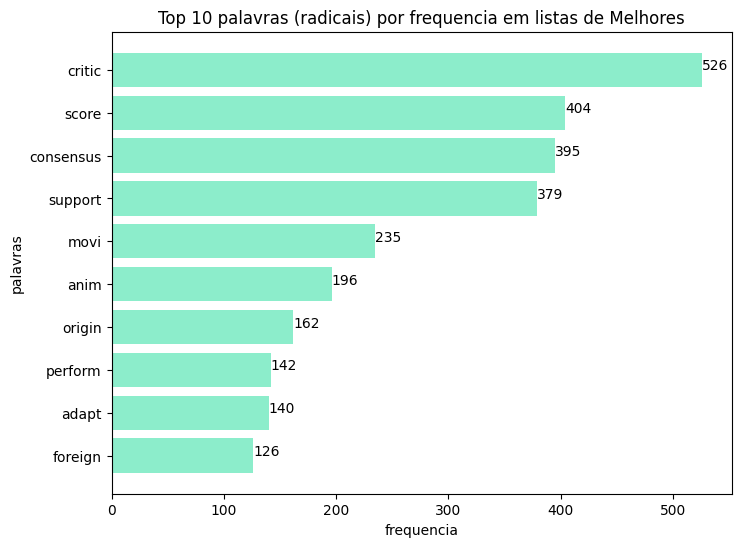

In [27]:
TopN(FrequenciaWords(mystring_melhores), "Top 10 palavras (radicais) por frequencia em listas de Melhores")

Gráfico de barras horizontais com o top 10 palavras mais recorrentes nos artigos classificados como "Piores"

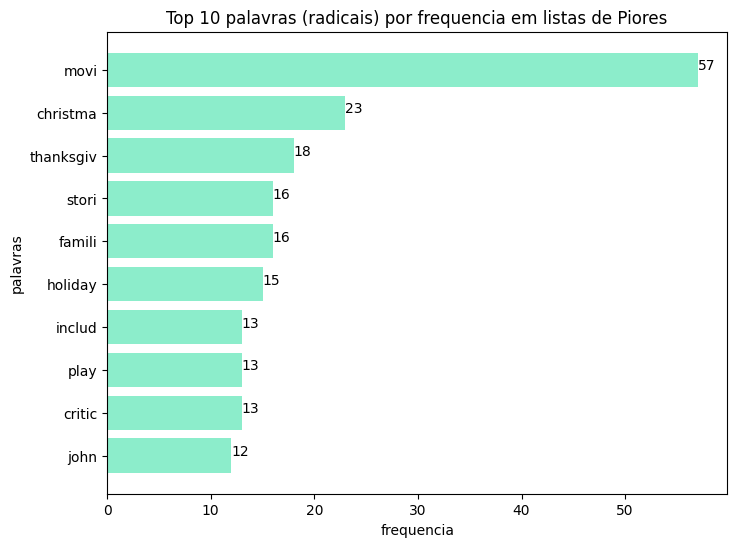

In [28]:
TopN(FrequenciaWords(mystring_piores), "Top 10 palavras (radicais) por frequencia em listas de Piores")

Gráfico de barras horizontais com o top 10 palavras mais recorrentes nos artigos classificados como "Melhores e Piores"

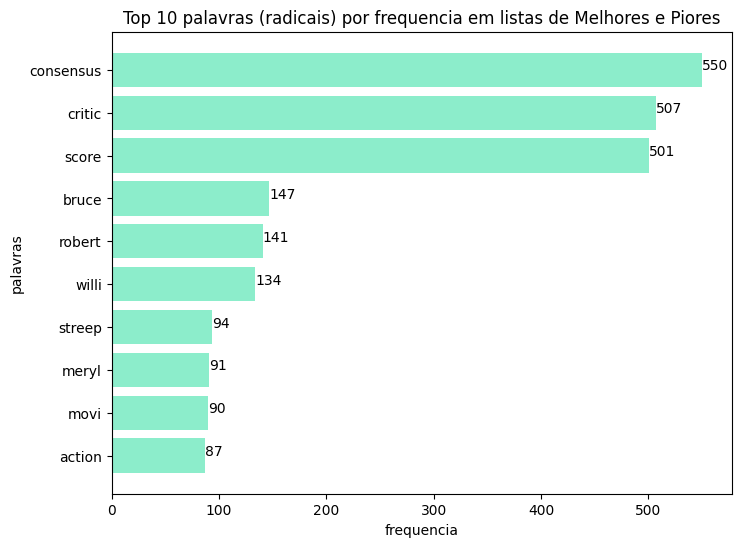

In [29]:
TopN(FrequenciaWords(mystring_melhorespiores), "Top 10 palavras (radicais) por frequencia em listas de Melhores e Piores")

Gráfico de barras horizontais com o top 10 palavras mais recorrentes nos artigos classificados como "Outros"

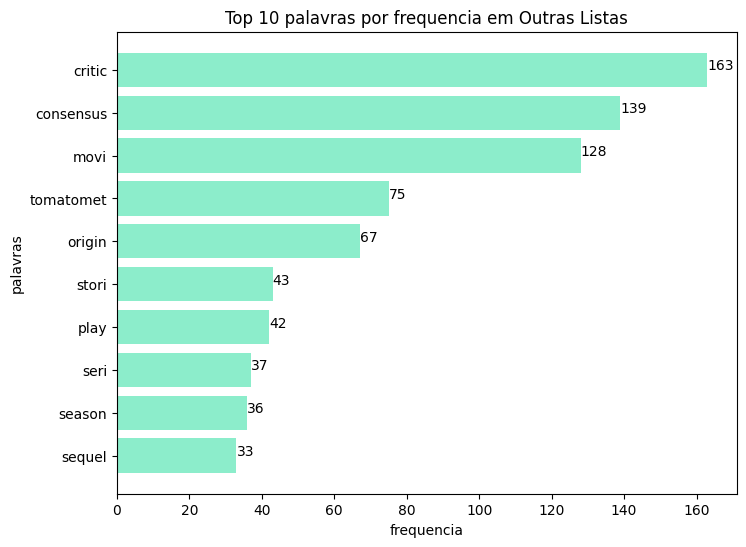

In [30]:
TopN(FrequenciaWords(mystring_outros), "Top 10 palavras por frequencia em Outras Listas")

Gráfico de barras com quantidade de artigos por classificação 

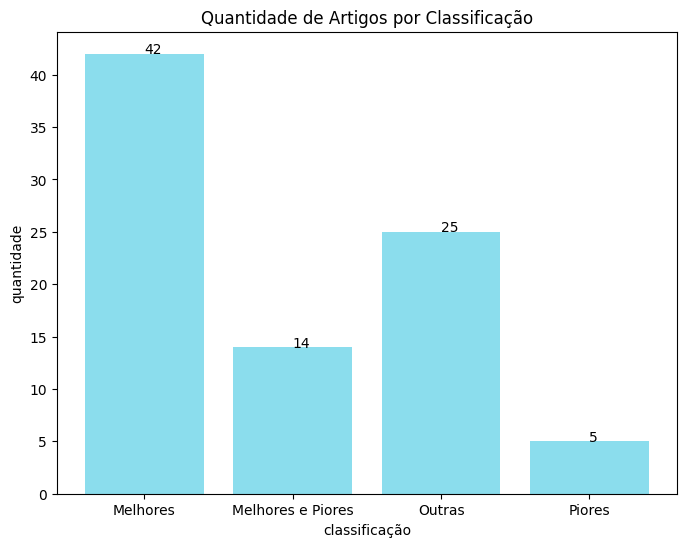

In [31]:
#agrupamento e agregação (contagem) de artigos por classificação
dfg = df1.groupby('classe', as_index=False)['titulo'].count().rename(columns={'count':'valuesum'})

#eixos do gráfico
x = dfg['classe']
y = dfg['titulo']

#tamanho gráfico
plt.figure(figsize=((8,6)))

#cria função para recuperar rótulo de valores
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

#cria gráfico de barras
bars = plt.bar(x,y, color = "#8BDDED")

#adiciona título do gráfico, dos eixos e o rótulos de valores
plt.xlabel("classificação")
plt.ylabel("quantidade")
plt.title("Quantidade de Artigos por Classificação")
addlabels(x, y)

#exibe e armazena gráfico
plt.savefig('grafico2.png', bbox_inches="tight")
plt.show()

Gráfico de barras horizontais com artigos de maior tamanho, de acordo com a classificação 

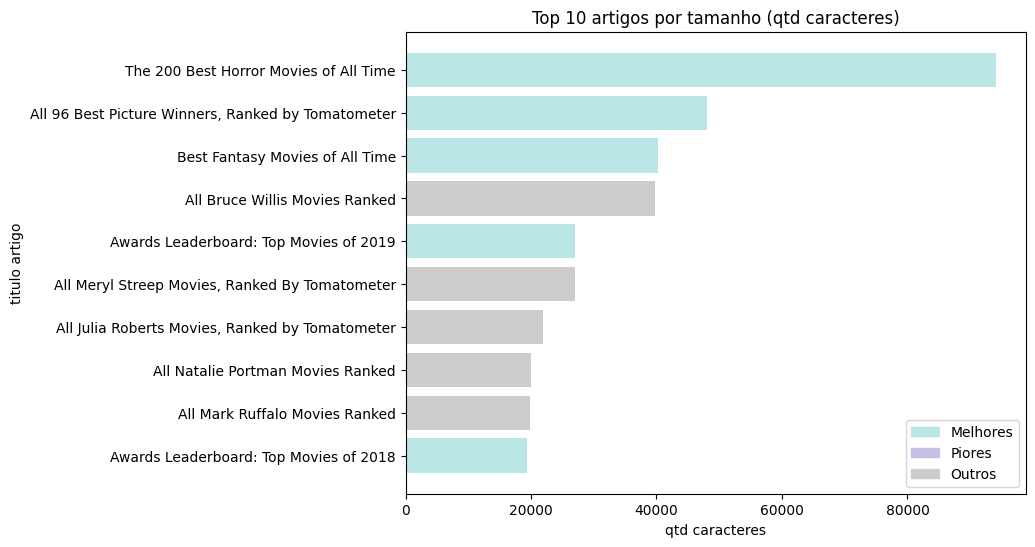

In [32]:
#cria dataframe com top 10 linhas, de acordo com a coluna "tamanho"
top_n = df1.sort_values(by=['tamanho'], ascending=[False]).head(10)
top_n.sort_values('tamanho',inplace=True)


x = top_n['titulo']
y = top_n['tamanho']

plt.figure(figsize=((8,6)))

plt.xlabel("qtd caracteres")
plt.ylabel("titulo artigo")
plt.title("Top 10 artigos por tamanho (qtd caracteres)")

#atribui cor hexadecimal para os valores "Melhores", "Piores" e demais valores da coluna "classe"
cor = [('#C8BFE7' if p == "Piores" else ('#BAE7E6' if p == "Melhores" else '#CCCCCC')) for p in top_n['classe']]
bars = plt.barh(x,y, color=cor)

#cria legenda de cores
labels_cor = [('Piores' if p == "Piores" else ('Melhores' if p == "Melhores" else 'Outros')) for p in top_n['classe']]
pop_m = mpatches.Patch(color='#BAE7E6', label='Melhores')
pop_p = mpatches.Patch(color='#C8BFE7', label='Piores')
pop_o = mpatches.Patch(color='#CCCCCC', label='Outros')
plt.legend(handles=[pop_m, pop_p, pop_o])

#exibe e armazena gráfico
plt.savefig('grafico3.png', bbox_inches="tight")
plt.show()